#### Utils lirairies

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings("ignore")

### Data loading and preprocessing

In [3]:
X=pd.read_csv("dataX.csv")
y=pd.read_csv("datay.csv")
print(X.shape)

(7199, 6)


Text(0.5, 1.0, 'Distribution of target variable')

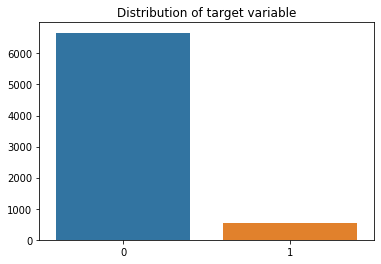

In [4]:
y_columns=y.columns
x = y[y_columns[0]].value_counts().values
sns.barplot([0,1], x)
plt.title("Distribution of target variable")

In [5]:
# Data normalization
scaler = MinMaxScaler(feature_range = (0, 1))
X = scaler.fit_transform(X)

In [6]:
# train test split
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
y_val=y_val.iloc[:,:].values
print(len(y_val))

1440


(10660, 6)
(10660,)


Text(0.5, 1.0, 'Distribution of target variable')

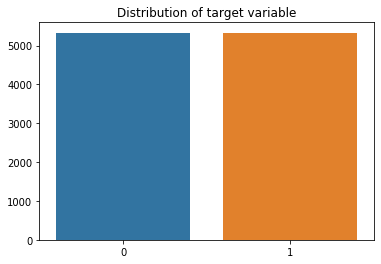

In [7]:
#Data augmentation
ran=RandomOverSampler()
X_tr,y_tr= ran.fit_resample(X_tr,y_tr)
print(X_tr.shape)
print(y_tr.shape)
x = np.array([len(y_tr[y_tr==0]),len(y_tr[y_tr==1])])
sns.barplot([0,1], x)
plt.title("Distribution of target variable")


# Pytorch ANN

In [292]:
from torch.utils.data import Dataset
import torch
class Dataset(Dataset):
    def __init__(self, X,y):
        self.X=torch.from_numpy(X).float()
        self.y=torch.tensor(y, dtype=torch.long)
        self.sample=len(y)

    def __len__(self):
        return self.sample

    def __getitem__(self, item):
        return self.X[item],self.y[item]


In [293]:
training_set=Dataset(X_tr,y_tr)

In [294]:
test_set=Dataset(X_val,y_val)

In [295]:
from torch.utils.data import DataLoader


In [296]:
training_generator=DataLoader(training_set, batch_size=32, shuffle=True)
test_generator=DataLoader(test_set, batch_size=32, shuffle=True)

In [297]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [298]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fc1=nn.Linear(in_features=6,out_features=10)
        self.bn1=nn.BatchNorm1d(num_features=10)
        self.fc2=nn.Linear(in_features=10,out_features=10)
        self.bn2=nn.BatchNorm1d(num_features=10)
        self.fc3=nn.Linear(in_features=10,out_features=6)
        self.bn3=nn.BatchNorm1d(num_features=6)
        self.fc4=nn.Linear(in_features=6,out_features=2)
    def forward(self,x):
        x=F.tanh(self.bn1(self.fc1(x)))
        x=F.tanh(self.bn2(self.fc2(x)))
        x=F.tanh(self.bn3(self.fc3(x)))
        x=F.log_softmax((self.fc4(x)),dim=1)
        
        return x
        
 
        

In [299]:
Net=Network()

In [300]:
print(Net)

Network(
  (fc1): Linear(in_features=6, out_features=10, bias=True)
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (bn2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=10, out_features=6, bias=True)
  (bn3): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=6, out_features=2, bias=True)
)


In [301]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(Net.parameters(), lr=0.001, momentum=0.9,weight_decay= 1e-6)
optimizer = torch.optim.Adam(Net.parameters(), lr=1e-5)
epochs=500

In [302]:
x,target=training_set[0:5]
logits=Net(x)
criterion(logits,target)

tensor(0.7759, grad_fn=<NllLossBackward>)

In [303]:
from torch.autograd import Variable
PATH="best_weigths"
test_interval=1
best_loss = 1e10
best_epoch = 0
Net.train()
num_iter_per_epoch = len(training_generator)
test_loss=[]
train_loss=[]
for epoch in range(epochs):
    epoch_loss=[]
    for iter, batch in enumerate(training_generator):
        x, label = batch
        x = Variable(x, requires_grad=True)
        optimizer.zero_grad()
        logits = Net(x)
        loss = criterion(logits, label)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss*len(label))
    tr_loss=sum(epoch_loss)/len(training_set)
    train_loss.append(tr_loss)
    if epoch % test_interval == 0:
        Net.eval()
        loss_ls = []
        for te_iter, te_batch in enumerate(test_generator):
            te_x, te_label = te_batch
            num_sample = len(te_label)
            with torch.no_grad():
                te_logits = Net(te_x)
            batch_loss= criterion(te_logits, torch.max(te_label, 1)[1])
            loss_ls.append(batch_loss * num_sample)
        te_loss = sum(loss_ls) / test_set.__len__()
        print("Epoch: {}/{} Train_loss:{:.2f} Test_loss:{:.2f}".format(
                epoch + 1,
                epochs,
                tr_loss,
                te_loss
                ))
        test_loss.append(te_loss)
        Net.train()
        if te_loss < best_loss:
                best_loss = te_loss
                best_epoch = epoch
                torch.save(Net.state_dict(), PATH)

Epoch: 1/500 Train_loss:0.65 Test_loss:0.68
Epoch: 2/500 Train_loss:0.64 Test_loss:0.68
Epoch: 3/500 Train_loss:0.63 Test_loss:0.68
Epoch: 4/500 Train_loss:0.62 Test_loss:0.65
Epoch: 5/500 Train_loss:0.61 Test_loss:0.68
Epoch: 6/500 Train_loss:0.61 Test_loss:0.65
Epoch: 7/500 Train_loss:0.60 Test_loss:0.64
Epoch: 8/500 Train_loss:0.59 Test_loss:0.63
Epoch: 9/500 Train_loss:0.59 Test_loss:0.61
Epoch: 10/500 Train_loss:0.58 Test_loss:0.61
Epoch: 11/500 Train_loss:0.58 Test_loss:0.65
Epoch: 12/500 Train_loss:0.57 Test_loss:0.60
Epoch: 13/500 Train_loss:0.56 Test_loss:0.59
Epoch: 14/500 Train_loss:0.56 Test_loss:0.59
Epoch: 15/500 Train_loss:0.56 Test_loss:0.53
Epoch: 16/500 Train_loss:0.55 Test_loss:0.52
Epoch: 17/500 Train_loss:0.54 Test_loss:0.60
Epoch: 18/500 Train_loss:0.54 Test_loss:0.56
Epoch: 19/500 Train_loss:0.54 Test_loss:0.57
Epoch: 20/500 Train_loss:0.53 Test_loss:0.54
Epoch: 21/500 Train_loss:0.53 Test_loss:0.58
Epoch: 22/500 Train_loss:0.52 Test_loss:0.59
Epoch: 23/500 Train

### Training curves

Text(0.5, 1.0, 'Test loss')

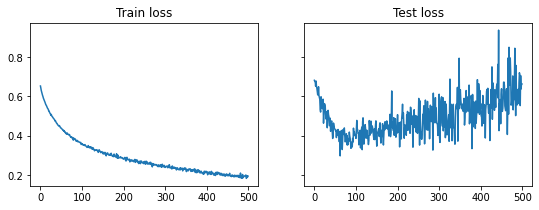

In [304]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
axs[0].plot(np.arange(epochs), train_loss)
axs[0].set_title("Train loss")
axs[1].plot(np.arange(epochs), test_loss)
axs[1].set_title("Test loss")

### Inference

In [306]:
Net.load_state_dict(torch.load(PATH))
Net.eval()

Network(
  (fc1): Linear(in_features=6, out_features=10, bias=True)
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (bn2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=10, out_features=6, bias=True)
  (bn3): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=6, out_features=2, bias=True)
)

In [323]:
from sklearn.metrics import roc_auc_score,confusion_matrix
x,target=test_set[:]
y_pred=Net(x)
y_pred=torch.argmax(y_pred, dim=1)
cm=confusion_matrix(target,y_pred)
PMC_accuracy=(cm[0][0]+cm[1][1])/sum(sum(cm))
PMC_roc=roc_auc_score(target,y_pred)
print("Acurracy score:",PMC_accuracy)
print("ROC score:",PMC_roc)
print("confusion matrix:")
print(cm)

Acurracy score: 0.9333333333333333
ROC score: 0.73151417870519
confusion matrix:
[[1292   43]
 [  53   52]]


In [324]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

classifiers=[RandomForestClassifier(),GradientBoostingClassifier(),AdaBoostClassifier(),
             DecisionTreeClassifier(),KNeighborsClassifier(),GaussianProcessClassifier()]
names=["RandomForestClassifier","GradientBoostingClassifier","AdaBoostClassifier",
             "DecisionTreeClassifier","KNeighborsClassifier","GaussianProcessClassifier"]
Acuracy=[]
ROC=[]

for i in range(len(classifiers)):
    print(names[i]+":")
    classifier=classifiers[i]
    classifier.fit(X_tr,y_tr)
    y_pred=classifier.predict(X_val)
    cm=confusion_matrix(y_val,y_pred)
    accuracy=(cm[0][0]+cm[1][1])/sum(sum(cm))
    roc=roc_auc_score(y_val,y_pred)
    Acuracy.append(accuracy)
    ROC.append(roc)
    print("Acurracy score:",accuracy)
    print("ROC score:",roc)
    print("confusion matrix:")
    print(cm)
    print("="*20)
names.append("PMC")
Acuracy.append(PMC_accuracy)
ROC.append(PMC_roc)
d={"classifiers":names,"accuracy":Acuracy,"roc score":ROC}  
df=pd.DataFrame(data=d)    

RandomForestClassifier:
Acurracy score: 0.9854166666666667
ROC score: 0.9833600856072766
confusion matrix:
[[1316   19]
 [   2  103]]
GradientBoostingClassifier:
Acurracy score: 0.9875
ROC score: 0.9888710540395933
confusion matrix:
[[1318   17]
 [   1  104]]
AdaBoostClassifier:
Acurracy score: 0.9861111111111112
ROC score: 0.9881219903691815
confusion matrix:
[[1316   19]
 [   1  104]]
DecisionTreeClassifier:
Acurracy score: 0.9833333333333333
ROC score: 0.9471375066880685
confusion matrix:
[[1321   14]
 [  10   95]]
KNeighborsClassifier:
Acurracy score: 0.8798611111111111
ROC score: 0.7465489566613162
confusion matrix:
[[1205  130]
 [  43   62]]
GaussianProcessClassifier:
Acurracy score: 0.8715277777777778
ROC score: 0.8122525414660245
confusion matrix:
[[1177  158]
 [  27   78]]


In [325]:
df

,classifiers,accuracy,roc score
0,RandomForestClassifier,0.985417,0.983360
1,GradientBoostingClassifier,0.987500,0.988871
2,AdaBoostClassifier,0.986111,0.988122
3,DecisionTreeClassifier,0.983333,0.947138
4,KNeighborsClassifier,0.879861,0.746549
5,GaussianProcessClassifier,0.871528,0.812253
6,PMC,0.933333,0.731514
